# Textile Defect Detection Project

## Importing Essential Libraries

In [ ]:
# import the libraries
import os
import glob
import pickle
import tensorflow as tf    # used for creating tensors out of the dataset and training the model
import tensorflow_hub as hub    # downloading and using pre-trained models
import numpy as np
import h5py   # to manipulate the dataset as it's in `.h5` format
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report   # essential for model's evaluation
from sklearn.metrics import f1_score
from tqdm import tqdm   # getting a progress bar for an iterable object

## Importing Dataset

**Dataset:** The project is based on the [public dataset](https://www.kaggle.com/datasets/belkhirnacim/textiledefectdetection?select=matchingtDATASET_test_32.h5) by the MVTec company. The main goal of this dataset is to explore self-supervised learning on texture images in order to solve anomaly detection problems and learn a robust representation of texture in lieu of traditional image processing features.

## Preprocessing the Dataset

### Pre-Exploration of the dataset

In [ ]:
# load the `train64.csv` file
train_df64 = pd.read_csv("/train64.csv")
train_df64["indication_type"] = train_df64.indication_type.apply(lambda row: "damaged" if row!="good" else "good")
train_df64["indication_value"] = train_df64.indication_value.apply(lambda row: 1 if row!=0 else 0)
train_df64.head()

,index,angle,indication_type,indication_value,split
0,48000,0,good,0,train
1,48001,80,good,0,train
2,48002,100,good,0,train
3,48003,100,good,0,train
4,48004,0,good,0,train


In [ ]:
# check the classes distribution
train_df64.indication_type.value_counts(normalize=True).round(2)

damaged    0.83
good       0.17
Name: indication_type, dtype: float64

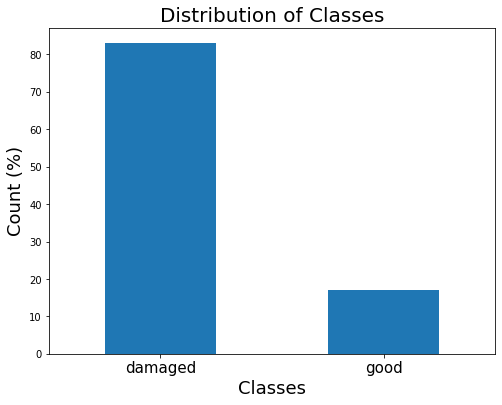

In [ ]:
# plot the distribution of classes
(train_df64.indication_type.value_counts(normalize=True).round(2)*100).to_frame().plot.bar(legend=False, figsize=(8, 6))
plt.xlabel('Classes', fontsize=18)
plt.ylabel("Count (%)", fontsize=18)
plt.title("Distribution of Classes", fontsize=20)
plt.xticks(rotation=0, fontsize=15);

**⚠ Imbalanced Training Dataset!**

### Preprocessing

The textile defect dataset actually has different classes like  good, cut, hole etc.. along with 8 different rotations `[0, 20, 40, 60, 80, 100, 120, 140]`. Given an image size, a train and test dataset are available with randomly generated patches. Source images from the train and test are non-overlapping.

***But this dataset is manipulated by `H5ToStorage` object for a binary classification task which contains the following preprocessing steps.***

1.   `64x64 pixels greyscale-image` train and test dataset  are selected.
2.   The above mentioned classes are collapsed into only *2 classes* `["damaged", "good"]` with TensorFlow for binary classification. *During this step, the imbalance of the classes is reduced by using data augmentation on `['good']` class training data to produce its three other versions per training sample.*
3.   The image and labels tensors are then loaded and saved back into the storage without burdening the memory, and resulting into a new dataset that is compatible with [tf.data.datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets). *During this stage, the `"good"` category will produce 4 extra records by data augmentation to eliminate the class imbalance.*
4.   `metadata` is created which contains *file-location as key* and the *rotation as it's value* for exploration purpose.


In [ ]:
# create an object that will take the dataset and produce the dataset in a format required for tensorflow dataset's API
class H5ToStorage:
  def __init__(self, hdf_path, ds_name="train"):
    self.path = hdf_path

    self.classes = []
    with h5py.File(self.path, 'r') as hf:
      for class_ in hf:
        self.classes.append(class_)

    self.name = ds_name

  # a generator to load the (img, class, angle)
  def generate_img_arr(self):
    for class_ in self.classes:
      with h5py.File(self.path, 'r') as hf:
        for angle in hf[class_]:
            for img in hf[class_][f"{angle}"]:
                yield img, class_, angle
  
  # utilize the generator to create new images and load it back to Storage
  def generate_train_dirs(self):
    # create the dataset's directories
    path = f"./dataset/{self.name}"
    os.makedirs(f"{path}/good/")
    os.makedirs(f"{path}/damaged/")

    # random_bright = tf.keras.layers.RandomBrightness(factor=0.05)
    random_flip = tf.keras.layers.RandomFlip("horizontal_and_vertical")

    gen = self.generate_img_arr()
    metadata = {}

    for i, data in enumerate(gen):
        img, label, angle = data
        if label == "good":
          for j in range(4):
            img_path = f"{path}/{label}/{i}_aug{j}.jpeg"
            img = random_flip(tf.expand_dims(np.squeeze(img), axis=2)*255., training=True)
            plt.imsave(img_path, np.squeeze(img), cmap="gray")
        else:
          img_path = f"{path}/damaged/{i}.jpeg"
          plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")

        metadata[img_path] = angle
    return metadata

  def generate_test_dirs(self):
    # create the dataset's directories
    path = f"./dataset/{self.name}"
    os.makedirs(f"{path}/good/")
    os.makedirs(f"{path}/damaged/")

    gen = self.generate_img_arr()
    metadata = {}

    for i, data in enumerate(gen):
        img, label, angle = data
        if label == "good":
          img_path = f"{path}/{label}/{i}.jpeg"
          plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")
        else:
          img_path = f"{path}/damaged/{i}.jpeg"
          plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")

        metadata[img_path] = angle

    return metadata

  def to_storage(self):
    if self.name == "train":
      self.generate_train_dirs()

    elif self.name == "test":
      self.generate_test_dirs()

In [ ]:
# generate train data
train_gen = H5ToStorage("matchingtDATASET_train_64.h5", "train")
train_dict = train_gen.to_storage()

In [ ]:
# generate test data
test_gen = H5ToStorage("matchingtDATASET_test_64.h5", "test")
test_dict = test_gen.to_storage()

In [ ]:
# train data & test data paths
test_dir = "dataset/test"
train_dir = "dataset/train"

In [ ]:
# create train data pipeline
IMG_SIZE = (64, 64) # define image size
train_data = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                         image_size=IMG_SIZE,
                                                         color_mode="grayscale",
                                                         label_mode="int", #  label type is encoding of the form `[1, 2, 3, ...]`
                                                         batch_size=64) # batch_size is 32 by default, but 128 will be used for this use-case
# classes in train_data
class_names = train_data.class_names
print(f"The class_names are as follows: {class_names}")

train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE).\
                        cache()


# create test data pipeline
test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        image_size=IMG_SIZE,
                                                        color_mode="grayscale",
                                                        shuffle=False,
                                                        batch_size=64,
                                                        label_mode="int")

test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE).\
                      cache() 

Found 108000 files belonging to 2 classes.

The class_names are as follows: ['damaged', 'good']

Found 36000 files belonging to 2 classes.


## Exploration of the dataset

Exploration of the dataset is required to get understanding about our classes and to further improve the dataset if required.

It will contain two parts:


*   Exploring the generated dataset and check if the class imbalance is reduced as expected.
*   Exploring the manipulated dataset to see if the classes are properly labeled.



In [ ]:
# check the proportions of classes
damaged_counts = 0
for _ in os.listdir(f"{train_dir}/damaged"):
  damaged_counts += 1

good_counts = 0
for _ in os.listdir(f"{train_dir}/good"):
  good_counts += 1

total = damaged_counts + good_counts

new_train_df64 = pd.Series({"damaged": damaged_counts/total,
                            "good": good_counts/total}).round(2)
new_train_df64

damaged    0.56
good       0.44
dtype: float64

**Class Imbalance is significantly reduced!**

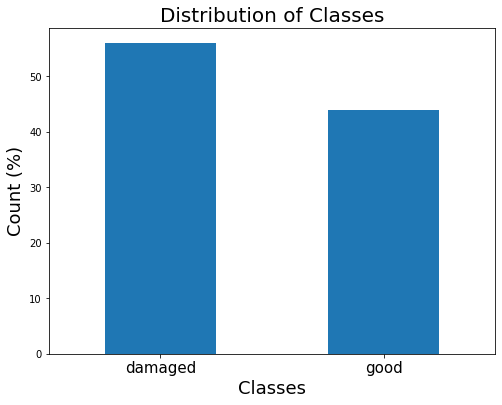

In [ ]:
# check the classes distribution
(new_train_df64*100).to_frame().plot.bar(legend=False, figsize=(8, 6))
plt.xlabel('Classes', fontsize=18)
plt.ylabel("Count (%)", fontsize=18)
plt.title("Distribution of Classes", fontsize=20)
plt.xticks(rotation=0, fontsize=15);

**Due to the data augmentation during the preprocessing step, the previously Imbalance of Classes has now been reduced significantly!**

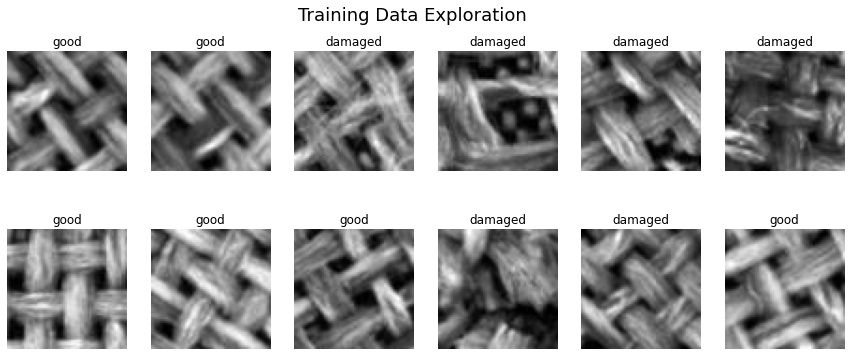

In [ ]:
# explore the train data
def explore_data(n_rows, n_cols, figsize):
    count = 0
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize) # plot 20 figures
    fig.suptitle("Training Data Exploration", fontsize=18, y=0.95)
    for data, ax in zip(train_data.shuffle(10000).take(1).unbatch(), axs.ravel()):
        img, label = data

        ax.axis("off")
        ax.set_title(f"{class_names[label]}")
        ax.imshow(np.squeeze(img), cmap="gray")

        count+=1
        if count == n_rows*n_cols:
          break;

explore_data(n_rows=2, n_cols=6, figsize=(15, 6))

## Model

In [ ]:
# create a baseline model to get the baseline metric
baseline_model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(64, 64, 1), name="input_layer"),
        tf.keras.layers.Conv2D(3, 1, padding="valid", activation="relu"),
        tf.keras.layers.Conv2D(16, 2, activation="relu"),
        tf.keras.layers.Conv2D(32, 2, activation="relu"),
        tf.keras.layers.Conv2D(64, 3, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 4, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(512, 4, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")
    ]
)

# get model summary
baseline_model.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 64, 64, 3)         6         

                                                                 

 conv2d_1 (Conv2D)           (None, 63, 63, 16)        208       

                                                                 

 conv2d_2 (Conv2D)           (None, 62, 62, 32)        2080      

                                                                 

 conv2d_3 (Conv2D)           (None, 60, 60, 64)        18496     

                                                                 

 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         

 )                                                               

                                                                 

 conv2d_4 (Conv2D)           (None, 27, 27, 128)       131200    

                                        

### Baseline Model's Training

In [ ]:
# define callbacks
# Setup ReduceLROnPlateau callback to reduce learning rate if model's val_loss doesn't improve for 1 epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=1,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3, # if val_accuracy decreases for 3 epochs in a row, stop training
                                                  restore_best_weights=True,
                                                  verbose=1)

In [ ]:
# compile the `baseline_model`
baseline_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

In [ ]:
# train the `baseline_model`
EPOCHS = 20
STEPS_PER_EPOCH = len(train_data)

baseline_training_history = baseline_model.fit(train_data,
                                               epochs=EPOCHS,
                                               steps_per_epoch=STEPS_PER_EPOCH,
                                               validation_data=test_data.shuffle(10000),
                                               validation_steps=int(0.5 * len(test_data)),
                                               callbacks=[reduce_lr, early_stopping]
                                               )

Epoch 1/20

1688/1688 [==============================] - 79s 41ms/step - loss: 0.5955 - accuracy: 0.8427 - val_loss: 0.4121 - val_accuracy: 0.8399 - lr: 0.0010

Epoch 2/20

1688/1688 [==============================] - 61s 36ms/step - loss: 0.3205 - accuracy: 0.8932 - val_loss: 0.3609 - val_accuracy: 0.8553 - lr: 0.0010

Epoch 3/20

1687/1688 [============================>.] - ETA: 0s - loss: 0.2906 - accuracy: 0.9019

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

1688/1688 [==============================] - 61s 36ms/step - loss: 0.2906 - accuracy: 0.9019 - val_loss: 0.3802 - val_accuracy: 0.8487 - lr: 0.0010

Epoch 4/20

1688/1688 [==============================] - 62s 37ms/step - loss: 0.2436 - accuracy: 0.9195 - val_loss: 0.2896 - val_accuracy: 0.8876 - lr: 2.0000e-04

Epoch 5/20

1688/1688 [==============================] - ETA: 0s - loss: 0.2340 - accuracy: 0.9224

Epoch 5: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

1688/168

### Getting the  Metrics

In [ ]:
# baseline_model's loss and accuracy
baseline_model.evaluate(test_data)

563/563 [==============================] - 9s 16ms/step - loss: 0.2932 - accuracy: 0.8871


[0.293188214302063, 0.8871111273765564]

Well, the baseline_model's accuracy doesn't look bad actually. Getting around 89% accuracy is pretty good though it mostly depend on the data quality and the use-case.

***But is accuracy actually a robust evaluation metric?***

In [ ]:
# function to get the model's ground truth and predicted labels
def get_labels(dataset, model):
    y_labels = []
    for _, label in tqdm(dataset.unbatch()):
        y_labels.append(label)

    y_preds = model.predict(dataset, verbose=1)
    return y_labels, y_preds

In [ ]:
# get the labels for baseline model
y_labels, y_preds = get_labels(test_data, baseline_model)

36000it [00:05, 7041.27it/s]


563/563 [==============================] - 6s 11ms/step


In [ ]:
# check the labels
y_labels[:2], np.round(y_preds[:2])

([<tf.Tensor: shape=(), dtype=int32, numpy=0>,
  <tf.Tensor: shape=(), dtype=int32, numpy=0>],
 array([[0.],
        [0.]], dtype=float32))

In [ ]:
# get the classification report
print("############### Classification Report ###############\n\n")
print(classification_report(y_labels, np.round(y_preds)))

############### Classification Report ###############





              precision    recall  f1-score   support



           0       0.96      0.91      0.93     30000

           1       0.63      0.79      0.70      6000



    accuracy                           0.89     36000

   macro avg       0.79      0.85      0.82     36000

weighted avg       0.90      0.89      0.89     36000




The precision, recall and f1-score of each classes tell a different story. It is a bit complicated to evaluate the results due to class imbalance in the test dataset. Anyways, the `f1-score` *(which considers both the precision and recall)* of `'good'` class is faring a lot worse than the the `'damaged'` class due to the lack of variety of class's training data quality in the dataset. *Although, the augmented training data had been generated but it wasn't too overly complicated due to the uniqueness of the dataset which also resulted in the lack of the variety of the training data for `['good']` class.*